In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

SyntaxError: invalid syntax (dataset.py, line 67)

### Load Model and Data

In [2]:
model_path = '/dfs/scratch0/chami/metal/logs/2019_02_20/RTE_21_25_34/'
task_name = 'RTE'
split = 'dev'

#Load model and data
model,dl = load_data_and_model(model_path,task_name,split)

#Create DataFrame of Raw Data, Predictions, and Labels
print('creating dataframe')
df_error = create_dataframe(task_name,model,dl)
print('created dataframe')
df_error.head()

#Save (and reload) DataFrame
csv_path = '/'.join(model_path.split('/')[0:-1])
filepath = f'{task_name}_{split}_error_analysis.tsv'
save_dataframe(df_error,filepath)
df_error = load_dataframe(filepath)

Using random seed: 904890.
Loading RTE Dataset



creating dataframe


100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


created dataframe
Saved dataframe to:  RTE_dev_error_analysis.tsv


## Sandbox for Error Analysis

**0. Some basic statistics.**

Confusion Matrix and Performance Metrics

In [3]:
from metal.analysis import confusion_matrix
#TODO: change to use the right function for label space change (0,1) to (1,2)
confusion_matrix( df_error['label']+1.,1*(df_error['score']>0.5)+1., pretty_print=True)
print()

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(df_error['label']+1., 1*(df_error['score']>0.5)+1., metric, probs=df_error['score'])
    print(f"{metric.capitalize()}: {score:.3f}")

        y=1    y=2   
 l=1    85     27    
 l=2    46     119   

Accuracy: 0.736
Precision: 0.759
Recall: 0.649
F1: 0.700


Plotting Predictions and Predicted Probabilistic Label Distribution

Accuracy:  0.7364620938628159


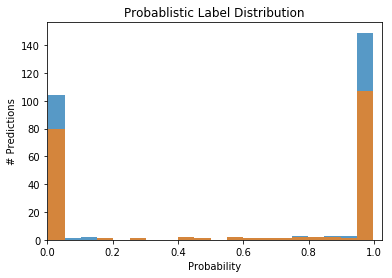

In [4]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_histogram
    )
plot_calibration_histogram(df_error['score'], df_error['label'], title="Probablistic Label Distribution", legend=[])

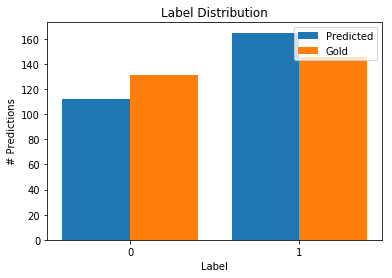

Accuracy:  0.7364620938628159


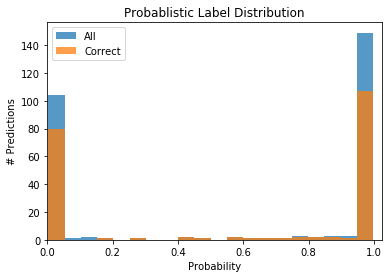

In [5]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_histogram
    )

plot_predictions_histogram((np.sign(df_error['score']-0.5)+1.)/2., df_error['label'], title="Label Distribution")
#plot_probabilities_histogram(df_error['score'], title="Probablistic Label Distribution")
plot_calibration_histogram(df_error['score'], df_error['label'], title="Probablistic Label Distribution")

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [6]:
print("\033[1mBARELY WRONG\033[0;0m")
for i in range(3):
    print_barely_pred(df_error,is_incorrect=True,thresh=0.2)
    
print("\033[1mBARELY RIGHT\033[0;0m")
for i in range(3):
    print_barely_pred(df_error,is_incorrect=False,thresh=0.15)

BARELY WRONG
ID:  86
sentence1: 	 the job gains mean that president bush can celebrate - albeit by a very fine margin - a net growth in jobs in the us economy in his first term in office . 
sentence2: 	 more jobs were created during president bush ' s first term . 
score: 	0.0074
label: 	1

ID:  213
sentence1: 	 za ##hi ha ##was ##s , egypt ' s pre - eminent archaeologist , revealed the first ancient artifacts which may lead to the discovery of cleopatra and marc antony ' s resting place . the expedition has found amulet ##s , 22 bronze coins cast with cleopatra ' s image and her name , a royal statue , an ala ##bas ##ter mask resembling marc antony , and a statue bust of cleopatra . " if you look at the face of mark antony , many believed he had this cl ##eft on his chin and that ' s why i thought this could be mark antony , " said ha ##was ##s . " in my opinion , if this tomb is found , it will be one of the most important discoveries of the 21st century because of the love between c

**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [7]:
print("\033[1mVERY WRONG\033[0;0m")
for i in range(3):
    print_very_wrong_pred(df_error,thresh=0.9)

VERY WRONG
ID:  237
sentence1: 	 california voters recall gray davis and elect arnold schwarz ##ene ##gger as their governor . 
sentence2: 	 california voters dumped gov . gray davis and replaced him with arnold schwarz ##ene ##gger . 
score: 	0.0480
label: 	1

ID:  270
sentence1: 	 the capital of slovenia is ljubljana , with 270 , 000 inhabitants . 
sentence2: 	 slovenia has 270 , 000 inhabitants . 
score: 	0.9934
label: 	0

ID:  70
sentence1: 	 about 33 . 5 million people live in this massive con ##ur ##bation . i would guess that 95 % of the 5 , 000 officially foreign - capital firms in japan are based in tokyo . 
sentence2: 	 about 33 . 5 mi ##ili ##on people live in tokyo . 
score: 	0.0056
label: 	1



**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [8]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(3):
    print_systematic_wrong(df_error)

SYSTEMATIC EXAMPLES


/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


award winning
supreme court said
foreign minister
22 year old
patti nson

sentence1: 	 rolling stone , one of the music industry ' s foremost publications , has found itself reporting false news g ##lean ##ed from a wikipedia article . the online edition of the magazine ' s rock & roll daily released an article entitled " halle berry set to ruin reputation . . . " on december 11 , reporting on the news that the actor had announced her intentions to release a musical album . the story was quickly picked up by the washington post , all headline news and other news agencies eager to report on the academy award - winning actress ' for ##ay into the musical world . the only trouble is , according to one of the album ' s alleged producers , scott st ##or ##ch , there is no such album . . . and he definitely hasn ' t produced three songs for it . 
sentence2: 	 halle berry works with scott st ##or ##ch . 
score: 	0.9965
label: 	0

award winning
court said
foreign minister
22 year old
mark anto

## Designing Labeling Functions

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

In [9]:
def LF_number(idx):
    sentence1_nums = [int(s) for s in df_error['sentence1'][idx].split() if s.isdigit()]
    sentence2_nums = [int(s) for s in df_error['sentence2'][idx].split() if s.isdigit()]
    common_nums = len(set(sentence1_nums).intersection(set(sentence2_nums)))
    
    if (sentence1_nums == []) or (sentence2_nums == []):
        return 0
    
    if common_nums > 0:
        return 2
    else:
        return 1

In [10]:
print_row(df_error.iloc[70])
print("LF_label: ", LF_number(70)-1)

print()
print()
print_row(df_error.iloc[254])
print("LF_label: ", LF_number(254)-1)

sentence1: 	 about 33 . 5 million people live in this massive con ##ur ##bation . i would guess that 95 % of the 5 , 000 officially foreign - capital firms in japan are based in tokyo . 
sentence2: 	 about 33 . 5 mi ##ili ##on people live in tokyo . 
score: 	0.0056
label: 	1

LF_label:  1


sentence1: 	 monica meadows , a 22 - year - old model from atlanta , was shot in the shoulder on a subway car in new york city . 
sentence2: 	 monica meadows , 23 , was shot in shoulder while riding a subway car in new york city 
score: 	0.9879
label: 	0

LF_label:  0


**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.

In [11]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

from collections import Counter
def common_words(s1,s2):
    s1_set = set(Counter(s1.split()))
    s2_set = set(Counter(s2.split()))
    return len(s1_set.intersection(s2_set))/float(min(len(s1_set),len(s2_set)))

In [12]:
def LF_words(idx):
    ratio = common_words(df_error['sentence1'][idx], df_error['sentence2'][idx])
    if ratio < 0.3:
        return 1
    if (ratio <= 1.0) and (ratio > 0.4):
        return 2
    else:
        return 0

In [13]:
print_row(df_error.iloc[150])
print("LF_label: ", LF_words(150)-1)

print()
print()
print_row(df_error.iloc[95])
print("LF_label: ", LF_words(95)-1)

sentence1: 	 quebec woman and her mother accused of plotting to kill a four - year - old girl . 
sentence2: 	 quebec woman murdered a four - year - old girl . 
score: 	0.0143
label: 	0

LF_label:  1


sentence1: 	 i asked myself how to understand the ' twilight ' s success . and i have come to the idea that when you really believe in something , sooner or later it will become real . so , i guess this is what happened with robert patti ##nson . last year he was just an unknown actor who ' s biggest role was in a pair of " harry potter " movies . now , not only that twilight is competing with ' harry potter ' , but robert patti ##nson is one of the most famous young actors who sucked $ 37 ##3 . 4 million from global box offices . so the movie about a vampire boy who falls in love with a normal girl , begun a real hysteria . and patti ##nson has a lot to do with it ! . 
sentence2: 	 robert patti ##nson is a vampire . 
score: 	0.9955
label: 	0

LF_label:  1


### Analyze Labeling Functions

In [14]:
L = np.zeros((np.shape(df_error)[0],2))
for i in range(df_error.shape[0]):
    L[i,0] = LF_number(i)
    L[i,1] = LF_words(i)

Labeling Function Summary

In [15]:
from metal.analysis import lf_summary
from scipy.sparse import csr_matrix    

L_sparse = csr_matrix(L)
lf_summary(L_sparse,Y=df_error.label+1)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1.0, 2.0]",0.158845,0.155235,0.025271,22,22,0.500000
1,"[1.0, 2.0]",0.949458,0.155235,0.025271,148,115,0.562738


In [16]:
incorrect = set(np.where(df_error.is_wrong == True)[0])
LF1_set = set(np.where(L[:,0]-1. == df_error.label)[0])
LF2_set = set(np.where(L[:,1]-1. == df_error.label)[0])

print("Percentage Corrected by LF_num: ", 100.*len(LF1_set.intersection(incorrect))/float(len(incorrect)))
print("Percentage Corrected by LF_words: ", 100.*len(LF2_set.intersection(incorrect))/float(len(incorrect)))

Percentage Corrected by LF_num:  6.8493150684931505
Percentage Corrected by LF_words:  31.506849315068493


## Using Model for Task A to Predict on Train Set for Task B

We start with QNLI and RTE since those are both about `entailment` and `not_entailment`

In [46]:
# model config (needs to be the same as parameters used for training)
bert_model = "bert-base-uncased"
max_len = 256
bert_output_dim = 768
max_datapoints = -1
dl_kwargs = {"batch_size": 32, "shuffle": False}

In [47]:
# 02/19/19
model_paths = {
    'MNLI_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/',
    'QNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/',
    'STSB': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/STSB_09_46_46/',
    'SST2': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/SST2_06_01_35/',
    'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/',
    'RTE':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/RTE_06_32_37/',
    'WNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/WNLI_06_38_32/',
    'QQP': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QQP_06_47_48/',
    'MRPC':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/MRPC_09_40_25/'
}

In [102]:
source_task_name = 'QNLI'
target_task_name = 'RTE'

#create source task
source_task = create_tasks(
    task_names=[source_task_name],
    bert_model=bert_model,
    max_len=max_len,
    dl_kwargs=dl_kwargs,
    bert_output_dim=bert_output_dim,
    splits=['test'],
    max_datapoints=max_datapoints,
)[0]

# load source model weights 
source_model_path = os.path.join(model_paths[source_task_name], 'best_model.pth')
source_model = MetalModel([source_task], verbose=False, device=0)
source_model.load_weights(source_model_path)
source_model.eval()
    
    
#create target task
target_task = create_tasks(
    task_names=[target_task_name],
    bert_model=bert_model,
    max_len=max_len,
    dl_kwargs=dl_kwargs,
    bert_output_dim=bert_output_dim,
    splits=['train'],
    max_datapoints=max_datapoints,
)[0]

# predict on target task train set
target_task.name = source_task_name #HACK FOR LINE 225 in METAL_MODEL.PY
Y, Y_probs, Y_preds = source_model._predict_probs(
    target_task, split='train', return_preds=True)

# true labels for target task train set
Y_true = []
for x, y in tqdm(list(target_task.data_loaders['train'])):
    Y_true += list(y.numpy())

Using random seed: 520674.
Loading QNLI Dataset


Using random seed: 797207.
Loading RTE Dataset


100%|██████████| 78/78 [00:00<00:00, 26170.36it/s]


In [103]:
confident_idx = list(np.where(np.abs(Y_probs[:,0]-0.5) >= 0.4)[0])
Y_true = np.array(Y_true)
print (f'Accuracy of {source_task_name} model on {target_task_name}: {np.mean(Y_preds[confident_idx] == Y_true[confident_idx])}')

Accuracy of QNLI model on RTE: 0.6487341772151899
